In [2]:
# Instalar bibliotecas necessárias
!pip install --quiet statsmodels openpyxl scikit-learn

In [1]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_excel("/content/drive/MyDrive/valor_efetivo/capacidade_pagamento/preco_soja_go.xlsx")
df.data = pd.to_datetime(df.data, dayfirst=True)
df.columns = ['data', 'preco_soja', 'preco_soja_atualizado']
df.sort_values('data', inplace=True)
df.set_index('data', inplace=True)
df = df.iloc[:,-1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2014-01-01 to 2025-06-01
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   preco_soja_atualizado  138 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [ ]:
df.shape

(138, 1)

In [30]:
# === ARIMA ===

# Decomposição e dessazonalização
ts = df['preco_soja_atualizado']
decomposition = seasonal_decompose(ts, model='multiplicative', period=12)
seasonal = decomposition.seasonal
ts_deseasonalized = ts / seasonal

# Ajuste ARIMA
model_arima = ARIMA(ts_deseasonalized, order=(2, 1, 2))
model_arima_fit = model_arima.fit()

# Separar treino/teste (80/20)
split = int(len(ts_deseasonalized) * 0.80)
test_dates = ts_deseasonalized.index[split+1:]
forecast_arima = model_arima_fit.forecast(steps=len(ts) - split - 1)

# Reaplicar sazonalidade
seasonal_avg = seasonal.groupby(seasonal.index.month).mean()
forecast_arima_real = forecast_arima.values * [seasonal_avg[d.month] for d in test_dates]
real = ts[test_dates]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

In [ ]:
split, len(ts), len(ts_deseasonalized)

(110, 138, 138)

In [ ]:
df_preco_dessazonalizado = pd.DataFrame(ts_deseasonalized, columns=['preco_soja_desazonalizado'])

In [41]:
# === LSTM ===

# Série diferenciada e dessazonalizada
ts_lstm = ts_deseasonalized.diff().dropna()
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_lstm.values.reshape(-1, 1))

# Criar janelas
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(ts_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [42]:
# Treino e teste
X_train, X_test = X[:split-window_size], X[split-window_size:]
y_train, y_test = y[:split-window_size], y[split-window_size:]
test_dates_lstm = ts_deseasonalized.index[split + window_size:]

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((86, 24, 1), (27, 24, 1), (86, 1), (27, 1))

In [56]:
# === LSTM com mais camadas ===
model = Sequential()
model.add(LSTM(200, return_sequences=True, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))

## Segunda camada LSTM (mais profunda)
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))

## Segunda camada LSTM (mais profunda)
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))

## terceira camada LSTM (mais profunda)
model.add(LSTM(25, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')


## Primeira camada LSTM (retorna sequências para empilhamento)
#model.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(window_size, 1)))
#model.add(Dropout(0.2))

## Segunda camada LSTM (mais profunda)
#model.add(LSTM(50, return_sequences=False, activation='relu'))
#model.add(Dropout(0.2))

#model.compile(optimizer=Adam(learning_rate=0.05), loss='mse')

# treinar
model.fit(X_train, y_train, epochs=500, verbose=0)

# Previsão
pred_lstm = model.predict(X_test)
pred_lstm_inv = scaler.inverse_transform(pred_lstm)

# Reintegrar os valores previstos com a série base
start_value = ts_deseasonalized.iloc[split + window_size - 1]
pred_lstm_deseasonalized = np.r_[start_value, start_value + np.cumsum(pred_lstm_inv.flatten())]

# Aplicar sazonalidade novamente com segurança
seasonality_lstm = [seasonal_avg.get(d.month, 1.0) for d in test_dates_lstm]
n = min(len(pred_lstm_deseasonalized[1:]), len(test_dates_lstm))
forecast_lstm_real = pred_lstm_deseasonalized[1:n+1] * [seasonal_avg.get(d.month, 1.0) for d in test_dates_lstm[:n]]
real_lstm = ts[test_dates_lstm[:n]]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


ARIMA - RMSE: 9.0678 | MAPE: 6.76%
LSTM  - RMSE: 4.7995 | MAPE: 3.67%


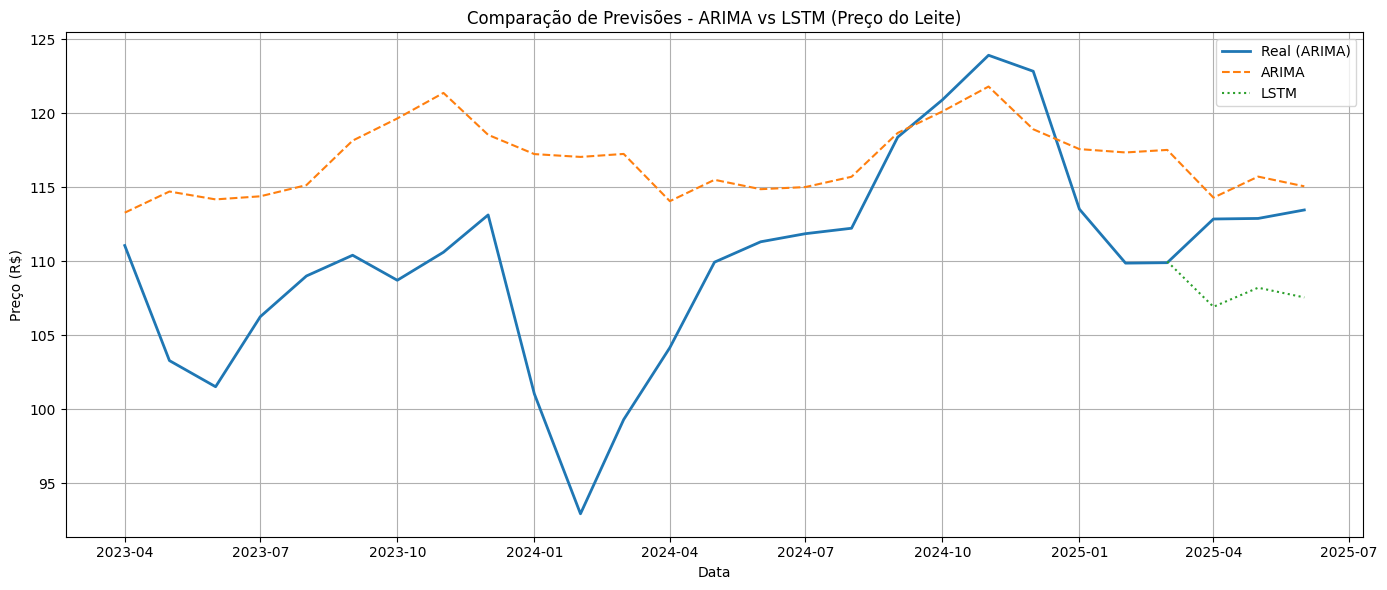

In [57]:
# === Avaliação ===

# Garantir que os índices são datetime
if isinstance(test_dates, pd.PeriodIndex):
    test_dates = test_dates.to_timestamp()

if isinstance(test_dates_lstm, pd.PeriodIndex):
    test_dates_lstm = test_dates_lstm.to_timestamp()

# ARIMA - Avaliação direta
rmse_arima = np.sqrt(mean_squared_error(real, forecast_arima_real))
mape_arima = mean_absolute_percentage_error(real, forecast_arima_real)

# LSTM - Alinhar índice com série real
n = min(len(pred_lstm_deseasonalized[1:]), len(test_dates_lstm))
forecast_lstm_real = pred_lstm_deseasonalized[1:n+1] * [seasonal_avg.get(d.month, 1.0) for d in test_dates_lstm[:n]]

# Garantir real_lstm somente com datas válidas
real_lstm = pd.Series(
    data=[ts.get(d, np.nan) for d in test_dates_lstm[:n]],
    index=pd.to_datetime(test_dates_lstm[:n])
).dropna()

# Alinhar previsão ao índice real
forecast_lstm_real = pd.Series(
    data=forecast_lstm_real[:len(real_lstm)],
    index=real_lstm.index
)

# LSTM - Avaliação
rmse_lstm = np.sqrt(mean_squared_error(real_lstm, forecast_lstm_real))
mape_lstm = mean_absolute_percentage_error(real_lstm, forecast_lstm_real)

# Resultados
print(f"ARIMA - RMSE: {rmse_arima:.4f} | MAPE: {mape_arima:.2%}")
print(f"LSTM  - RMSE: {rmse_lstm:.4f} | MAPE: {mape_lstm:.2%}")

# === Gráfico Final ===
plt.figure(figsize=(14,6))
plt.plot(real.index, real.values, label='Real (ARIMA)', linewidth=2)
plt.plot(real.index, forecast_arima_real, label='ARIMA', linestyle='--')
plt.plot(real_lstm.index, forecast_lstm_real, label='LSTM', linestyle=':')
plt.title("Comparação de Previsões - ARIMA vs LSTM (Preço do Leite)")
plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

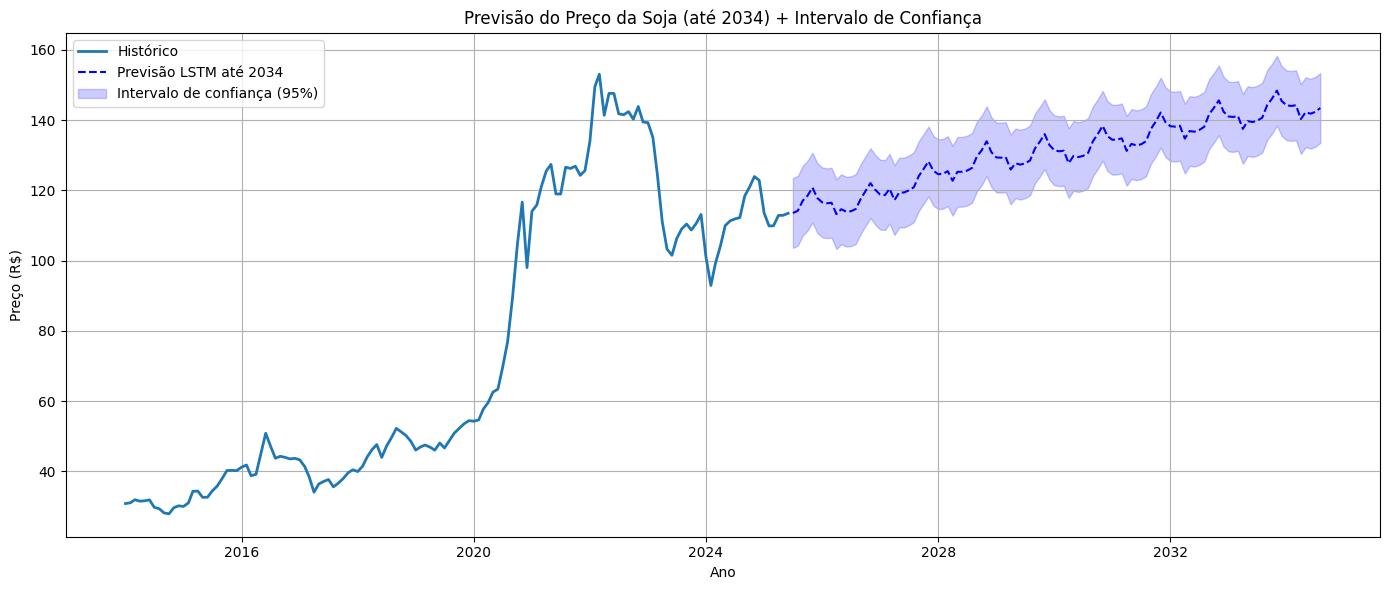

In [59]:
# Previsão futura até 08/2034
from datetime import datetime
from google.colab import files

# Previsão futura até 08/2034
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), end="2034-08-01", freq='MS')
n_future = len(future_dates)

# Usar a última janela da série original
input_seq = ts_scaled[-window_size:].reshape(1, window_size, 1)
future_preds = []

for _ in range(n_future):
    next_val = model.predict(input_seq, verbose=0)
    future_preds.append(next_val[0,0])
    next_val_reshaped = next_val.reshape(1, 1, 1)
    input_seq = np.concatenate((input_seq[:, 1:, :], next_val_reshaped), axis=1)

# Desnormalizar e reintegrar
future_diff = scaler.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()
last_value = ts_deseasonalized.iloc[-1]
reconstructed = [last_value]
for diff in future_diff:
    reconstructed.append(reconstructed[-1] + diff)
reconstructed = reconstructed[1:]

# Aplicar sazonalidade futura
future_seasonality = [seasonal_avg[d.month] for d in future_dates]
forecast_future = np.array(reconstructed) * future_seasonality

# === Estimar desvio padrão do erro da LSTM (com base no conjunto de teste) ===
residuos = y_test.flatten() - pred_lstm.flatten()
desvio_padrao = np.std(scaler.inverse_transform(residuos.reshape(-1,1)))

# === Gerar margens de confiança para as projeções ===
margin = 1.96 * desvio_padrao  # intervalo de 95%

forecast_upper = forecast_future + margin
forecast_lower = forecast_future - margin

# Criar DataFrame final com intervalo
forecast_df = pd.DataFrame({
    'data': future_dates,
    'preco_previsto_lstm': forecast_future,
    'limite_superior': forecast_upper,
    'limite_inferior': forecast_lower
})
forecast_df.set_index('data', inplace=True)

# Exportar para Excel
excel_path = "/content/drive/MyDrive/valor_efetivo/capacidade_pagamento/previsao_lstm_soja_2034.xlsx"
forecast_df.to_excel(excel_path)
files.download(excel_path)

# === Visualizar com intervalo de confiança ===
plt.figure(figsize=(14,6))
plt.plot(ts, label='Histórico', linewidth=2)
plt.plot(forecast_df['preco_previsto_lstm'], label='Previsão LSTM até 2034', linestyle='--', color='blue')
plt.fill_between(
    forecast_df.index,
    forecast_df['limite_inferior'],
    forecast_df['limite_superior'],
    color='blue', alpha=0.2, label='Intervalo de confiança (95%)'
)

plt.title("Previsão do Preço da Soja (até 2034) + Intervalo de Confiança")
plt.xlabel("Ano")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Preço do Milho

In [60]:
# Preço do milho
df=pd.read_excel("/content/drive/MyDrive/valor_efetivo/capacidade_pagamento/preco_milho_go.xlsx")
df.data = pd.to_datetime(df.data, dayfirst=True)
df.columns = ['data', 'preco_soja', 'preco_milho_atualizado']
df.sort_values('data', inplace=True)
df.set_index('data', inplace=True)
df = df.iloc[:,-1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2014-01-01 to 2025-06-01
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   preco_milho_atualizado  138 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [61]:
# === ARIMA ===

# Decomposição e dessazonalização
ts = df['preco_milho_atualizado']
decomposition = seasonal_decompose(ts, model='multiplicative', period=12)
seasonal = decomposition.seasonal
ts_deseasonalized = ts / seasonal

# Ajuste ARIMA
model_arima = ARIMA(ts_deseasonalized, order=(2, 1, 2))
model_arima_fit = model_arima.fit()

# Separar treino/teste (80/20)
split = int(len(ts_deseasonalized) * 0.9)
test_dates = ts_deseasonalized.index[split+1:]
forecast_arima = model_arima_fit.forecast(steps=len(ts) - split - 1)

# Reaplicar sazonalidade com segurança
seasonal_avg = seasonal.groupby(seasonal.index.month).mean()
seasonality_arima = [seasonal_avg.get(d.month, 1.0) for d in test_dates]
forecast_arima_real = forecast_arima.values * seasonality_arima
real = ts[test_dates]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
df_preco_dessazonalizado = pd.concat([df_preco_dessazonalizado, pd.DataFrame(ts_deseasonalized, columns=['preco_milho_desazonalizado'])], axis=1)
df_preco_dessazonalizado.to_excel("/content/drive/MyDrive/valor_efetivo/capacidade_pagamento/soja_e_milho_dessazonalizado.xlsx")

In [62]:
# === LSTM ===
# Série diferenciada e dessazonalizada
ts_lstm = ts_deseasonalized.diff().dropna()
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_lstm.values.reshape(-1, 1))

# Criar janelas
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(ts_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [63]:
# Treino e teste
X_train, X_test = X[:split-window_size], X[split-window_size:]
y_train, y_test = y[:split-window_size], y[split-window_size:]
test_dates_lstm = ts_deseasonalized.index[split + window_size:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((118, 6, 1), (13, 6, 1), (118, 1), (13, 1))

In [64]:
# === LSTM com uma camada ===
model = Sequential()

# Primeira camada LSTM (retorna sequências para empilhamento)
model.add(LSTM(200, return_sequences=True, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))

# Segunda camada LSTM (mais profunda)
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))

# Terceira camada LSTM (mais profunda)
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))

# Quarta camada LSTM (mais profunda)
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(0.2))

# Camada de saída densa
model.add(Dense(1))

# Compilar
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

# Treinamento
model.fit(X_train, y_train, epochs=500, verbose=0)

# Previsão no conjunto de teste
pred_lstm = model.predict(X_test)
pred_lstm_inv = scaler.inverse_transform(pred_lstm)

# Reintegrar os valores previstos com a série base
start_value = ts_deseasonalized.iloc[split + window_size - 1]
pred_lstm_deseasonalized = np.r_[start_value, start_value + np.cumsum(pred_lstm_inv.flatten())]

# Aplicar sazonalidade novamente com segurança
seasonality_lstm = [seasonal_avg.get(d.month, 1.0) for d in test_dates_lstm]
n = min(len(pred_lstm_deseasonalized[1:]), len(test_dates_lstm))
forecast_lstm_real = pred_lstm_deseasonalized[1:n+1] * [seasonal_avg.get(d.month, 1.0) for d in test_dates_lstm[:n]]
real_lstm = ts[test_dates_lstm[:n]]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


ARIMA - RMSE: 9.8370 | MAPE: 13.44%
LSTM  - RMSE: 10.0448 | MAPE: 16.57%


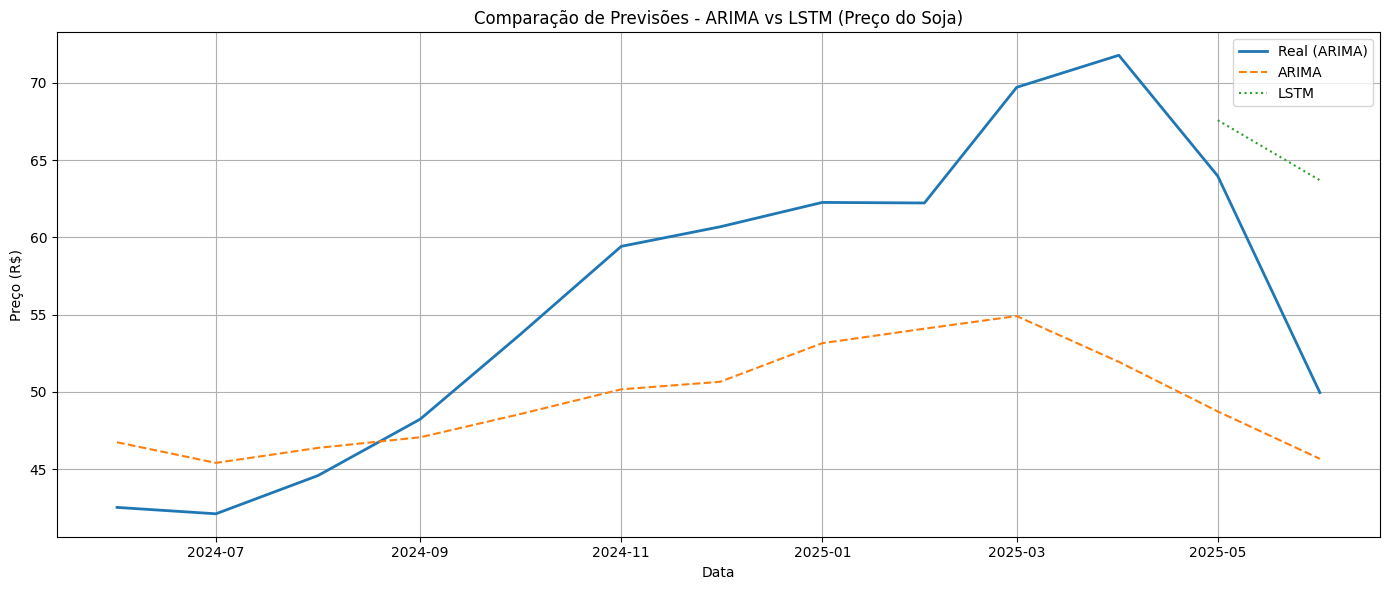

In [65]:
# === Avaliação ===

# Garantir que os índices são datetime
if isinstance(test_dates, pd.PeriodIndex):
    test_dates = test_dates.to_timestamp()

if isinstance(test_dates_lstm, pd.PeriodIndex):
    test_dates_lstm = test_dates_lstm.to_timestamp()

# ARIMA - Avaliação direta
rmse_arima = np.sqrt(mean_squared_error(real, forecast_arima_real))
mape_arima = mean_absolute_percentage_error(real, forecast_arima_real)

# LSTM - Alinhar índice com série real
n = min(len(pred_lstm_deseasonalized[1:]), len(test_dates_lstm))
forecast_lstm_real = pred_lstm_deseasonalized[1:n+1] * [seasonal_avg.get(d.month, 1.0) for d in test_dates_lstm[:n]]

# Garantir real_lstm somente com datas válidas
real_lstm = pd.Series(
    data=[ts.get(d, np.nan) for d in test_dates_lstm[:n]],
    index=pd.to_datetime(test_dates_lstm[:n])
).dropna()

# Alinhar previsão ao índice real
forecast_lstm_real = pd.Series(
    data=forecast_lstm_real[:len(real_lstm)],
    index=real_lstm.index
)

# LSTM - Avaliação
rmse_lstm = np.sqrt(mean_squared_error(real_lstm, forecast_lstm_real))
mape_lstm = mean_absolute_percentage_error(real_lstm, forecast_lstm_real)

# Resultados
print(f"ARIMA - RMSE: {rmse_arima:.4f} | MAPE: {mape_arima:.2%}")
print(f"LSTM  - RMSE: {rmse_lstm:.4f} | MAPE: {mape_lstm:.2%}")

# === Gráfico Final ===
plt.figure(figsize=(14,6))
plt.plot(real.index, real.values, label='Real (ARIMA)', linewidth=2)
plt.plot(real.index, forecast_arima_real, label='ARIMA', linestyle='--')
plt.plot(real_lstm.index, forecast_lstm_real, label='LSTM', linestyle=':')
plt.title("Comparação de Previsões - ARIMA vs LSTM (Preço do Soja)")
plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

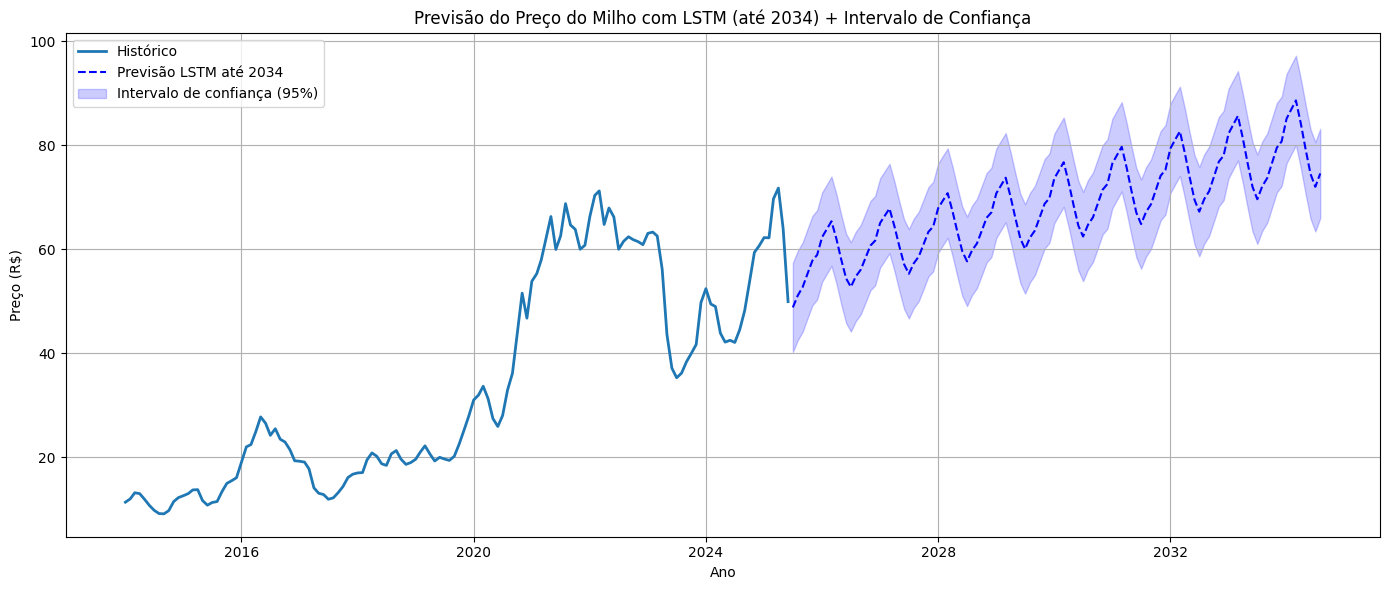

In [67]:
# Previsão futura até 08/2034
from datetime import datetime
from google.colab import files

# Previsão futura até 08/2034
#ts = ts.to_timestamp()  # converte para DatetimeIndex
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), end="2034-08-01", freq='MS')
n_future = len(future_dates)

# Usar a última janela da série original
input_seq = ts_scaled[-window_size:].reshape(1, window_size, 1)
future_preds = []

for _ in range(n_future):
    next_val = model.predict(input_seq, verbose=0)
    future_preds.append(next_val[0,0])
    next_val_reshaped = next_val.reshape(1, 1, 1)  # <- Corrigido aqui
    input_seq = np.concatenate((input_seq[:, 1:, :], next_val_reshaped), axis=1)

# Desnormalizar e reintegrar
future_diff = scaler.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()
last_value = ts_deseasonalized.iloc[-1]
reconstructed = [last_value]
for diff in future_diff:
    reconstructed.append(reconstructed[-1] + diff)
reconstructed = reconstructed[1:]

# Aplicar sazonalidade futura
future_seasonality = [seasonal_avg[d.month] for d in future_dates]
forecast_future = np.array(reconstructed) * future_seasonality

# === Estimar desvio padrão do erro da LSTM (com base no conjunto de teste) ===
residuos = y_test.flatten() - pred_lstm.flatten()
desvio_padrao = np.std(scaler.inverse_transform(residuos.reshape(-1,1)))

# === Gerar margens de confiança para as projeções ===
margin = 1.96 * desvio_padrao  # intervalo de 95%

forecast_upper = forecast_future + margin
forecast_lower = forecast_future - margin

# Criar DataFrame final com intervalo
forecast_df = pd.DataFrame({
    'data': future_dates,
    'preco_previsto_lstm': forecast_future,
    'limite_superior': forecast_upper,
    'limite_inferior': forecast_lower
})
forecast_df.set_index('data', inplace=True)

# Exportar para Excel
excel_path = "/content/drive/MyDrive/valor_efetivo/capacidade_pagamento/previsao_lstm_milho_2034.xlsx"
forecast_df.to_excel(excel_path)
files.download(excel_path)

# === Visualizar com intervalo de confiança ===
plt.figure(figsize=(14,6))
plt.plot(ts, label='Histórico', linewidth=2)
plt.plot(forecast_df['preco_previsto_lstm'], label='Previsão LSTM até 2034', linestyle='--', color='blue')
plt.fill_between(
    forecast_df.index,
    forecast_df['limite_inferior'],
    forecast_df['limite_superior'],
    color='blue', alpha=0.2, label='Intervalo de confiança (95%)'
)

plt.title("Previsão do Preço do Milho com LSTM (até 2034) + Intervalo de Confiança")
plt.xlabel("Ano")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

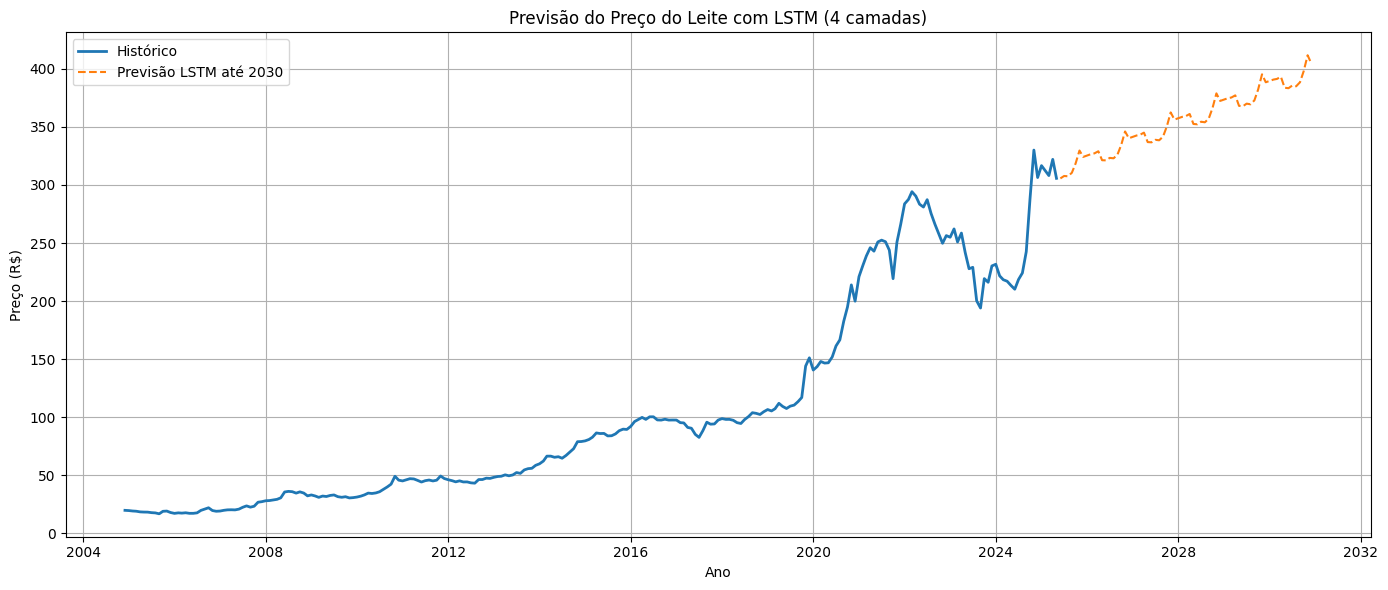

In [ ]:
# Previsão futura até 12/2030
from datetime import datetime
from google.colab import files

# Previsão futura até 12/2030
#ts = ts.to_timestamp()  # converte para DatetimeIndex
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), end="2030-12-01", freq='MS')
n_future = len(future_dates)

# Usar a última janela da série original
input_seq = ts_scaled[-window_size:].reshape(1, window_size, 1)
future_preds = []

for _ in range(n_future):
    next_val = model.predict(input_seq, verbose=0)
    future_preds.append(next_val[0,0])
    next_val_reshaped = next_val.reshape(1, 1, 1)  # <- Corrigido aqui
    input_seq = np.concatenate((input_seq[:, 1:, :], next_val_reshaped), axis=1)

# Desnormalizar e reintegrar
future_diff = scaler.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()
last_value = ts_deseasonalized.iloc[-1]
reconstructed = [last_value]
for diff in future_diff:
    reconstructed.append(reconstructed[-1] + diff)
reconstructed = reconstructed[1:]

# Aplicar sazonalidade futura
future_seasonality = [seasonal_avg[d.month] for d in future_dates]
forecast_future = np.array(reconstructed) * future_seasonality

# Criar DataFrame final
forecast_df = pd.DataFrame({
    'data': future_dates,
    'preco_previsto_lstm': forecast_future
})

forecast_df.set_index('data', inplace=True)

# Exportar para Excel
excel_path = "/content/drive/MyDrive/valor_efetivo/capacidade_pagamento/previsao_lstm_simples_ate_2030.xlsx"
forecast_df.to_excel(excel_path)
files.download(excel_path)

# Visualizar
plt.figure(figsize=(14,6))
plt.plot(ts, label='Histórico', linewidth=2)
plt.plot(forecast_df, label='Previsão LSTM até 2030', linestyle='--')
plt.title("Previsão do Preço do Leite com LSTM (4 camadas)")
plt.xlabel("Ano")
plt.ylabel("Preço (R$)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_filtered = df[df.index > pd.Period("2004-11", freq='M')].copy()
df_filtered.to_excel("/content/drive/MyDrive/valor_efetivo/capacidade_pagamento/boi_gordo_apos_2004.xlsx", index=True)